In [1]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.1'
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [893 kB]
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,858 kB]
Get:13 http://security.ubuntu

In [2]:
# Import packages
from pyspark.sql import SparkSession
import time
import pandas as pd
import matplotlib.pyplot as plt

# Create a SparkSession
spark = SparkSession.builder\
    .appName("SparkSQL")\
    .config("spark.sql.debug.maxToStringFields", 2000)\
    .config("spark.driver.memory", "2g")\
    .getOrCreate()

In [3]:
# Read in data from the UCI Repo
from pyspark import SparkFiles
hands_url = "https://archive.ics.uci.edu/static/public/158/data.csv"
spark.sparkContext.addFile(hands_url)
hands_df = spark.read.csv(SparkFiles.get("data.csv"), sep=",", header=True)

# Show the poker hand data.
hands_df.show()

+---+---+---+---+---+---+---+---+---+---+-----+
| S1| C1| S2| C2| S3| C3| S4| C4| S5| C5|CLASS|
+---+---+---+---+---+---+---+---+---+---+-----+
|  1| 10|  1| 11|  1| 13|  1| 12|  1|  1|    9|
|  2| 11|  2| 13|  2| 10|  2| 12|  2|  1|    9|
|  3| 12|  3| 11|  3| 13|  3| 10|  3|  1|    9|
|  4| 10|  4| 11|  4|  1|  4| 13|  4| 12|    9|
|  4|  1|  4| 13|  4| 12|  4| 11|  4| 10|    9|
|  1|  2|  1|  4|  1|  5|  1|  3|  1|  6|    8|
|  1|  9|  1| 12|  1| 10|  1| 11|  1| 13|    8|
|  2|  1|  2|  2|  2|  3|  2|  4|  2|  5|    8|
|  3|  5|  3|  6|  3|  9|  3|  7|  3|  8|    8|
|  4|  1|  4|  4|  4|  2|  4|  3|  4|  5|    8|
|  1|  1|  2|  1|  3|  9|  1|  5|  2|  3|    1|
|  2|  6|  2|  1|  4| 13|  2|  4|  4|  9|    0|
|  1| 10|  4|  6|  1|  2|  1|  1|  3|  8|    0|
|  2| 13|  2|  1|  4|  4|  1|  5|  2| 11|    0|
|  3|  8|  4| 12|  3|  9|  4|  2|  3|  2|    1|
|  1|  3|  4|  7|  1|  5|  2|  4|  4| 13|    0|
|  1|  4|  1|  1|  1|  3|  3|  5|  3|  2|    4|
|  3|  8|  3| 12|  2|  7|  2|  6|  1|  2

In [4]:
# Create a temporary view for our dataframe
hands_df.createOrReplaceTempView('hands')

In [5]:
start_time = time.time()

spark.sql("""

SELECT COUNT(Class) AS Occurrences
FROM hands

""").show()

print("--- %s seconds ---" % (time.time() - start_time))

+-----------+
|Occurrences|
+-----------+
|    1025010|
+-----------+

--- 4.48937726020813 seconds ---


In [6]:
# Data exploration through queries...

start_time = time.time()

# Execute the SQL query and store the result in a DataFrame
hand_occurances = spark.sql("""
SELECT Class, COUNT(Class) AS Occurrences
FROM hands
GROUP BY Class
ORDER BY Occurrences DESC
""")

# Show the result
hand_occurances.show()

print("--- %s seconds ---" % (time.time() - start_time))

+-----+-----------+
|Class|Occurrences|
+-----+-----------+
|    0|     513702|
|    1|     433097|
|    2|      48828|
|    3|      21634|
|    4|       3978|
|    5|       2050|
|    6|       1460|
|    7|        236|
|    8|         17|
|    9|          8|
+-----+-----------+

--- 3.967346429824829 seconds ---


             Class  Occurrences
0  Nothing in hand       513702
1         One pair       433097
2        Two pairs        48828
3  Three of a kind        21634
4         Straight         3978
5            Flush         2050
6       Full house         1460
7   Four of a kind          236
8   Straight flush           17
9      Royal flush            8


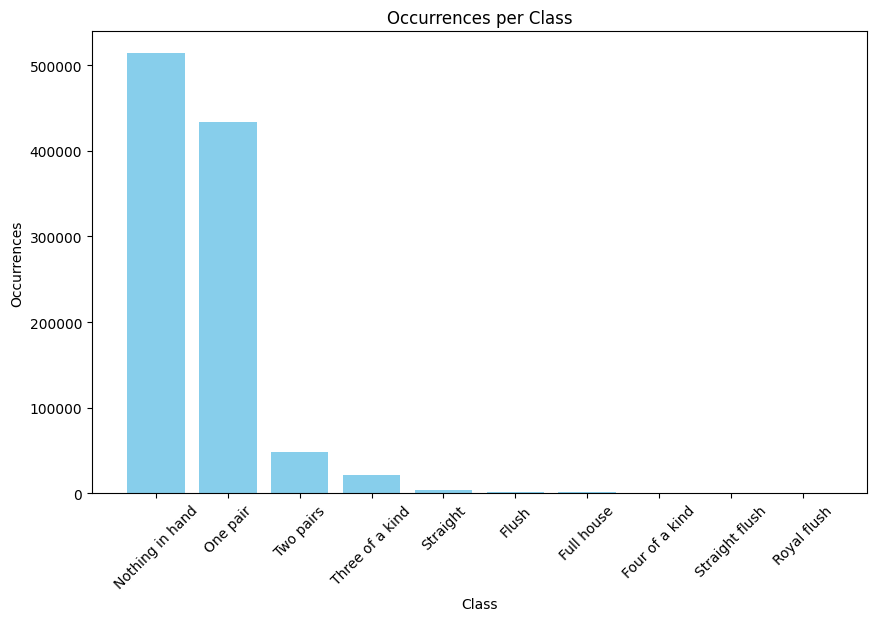

In [7]:
pandasdf = hand_occurances.select("*").toPandas()

pandasdf["Class"] = pandasdf["Class"].astype(int)

class_mapping = {
    0: "Nothing in hand",
    1: "One pair",
    2: "Two pairs",
    3: "Three of a kind",
    4: "Straight",
    5: "Flush",
    6: "Full house",
    7: "Four of a kind",
    8: "Straight flush",
    9: "Royal flush"
}

pandasdf["Class"] = pandasdf["Class"].map(class_mapping)

print(pandasdf)

# Create a bar graph
plt.figure(figsize=(10, 6))
plt.bar(pandasdf["Class"], pandasdf["Occurrences"], color='skyblue')
plt.xlabel("Class")
plt.ylabel("Occurrences")
plt.title("Occurrences per Class")
plt.xticks(pandasdf["Class"], rotation=45)
plt.show()


In [8]:
# Here we have added the hint to Broadcast the lookup table.
start_time = time.time()

hand_percentages = spark.sql("""
SELECT Class, ((COUNT(Class) / 1025010)*100) AS Occurrences
FROM hands
GROUP BY Class
ORDER BY Occurrences DESC
""")

hand_percentages.show()

print("--- %s seconds ---" % (time.time() - start_time))

+-----+--------------------+
|Class|         Occurrences|
+-----+--------------------+
|    0|  50.116779348494155|
|    1|  42.252953629720686|
|    2|   4.763660842333246|
|    3|  2.1106135549897074|
|    4| 0.38809377469488104|
|    5|  0.1999980487995239|
|    6| 0.14243763475478288|
|    7| 0.02302416561789641|
|    8|0.001658520404678...|
|    9|7.804801904371665E-4|
+-----+--------------------+

--- 3.702448606491089 seconds ---


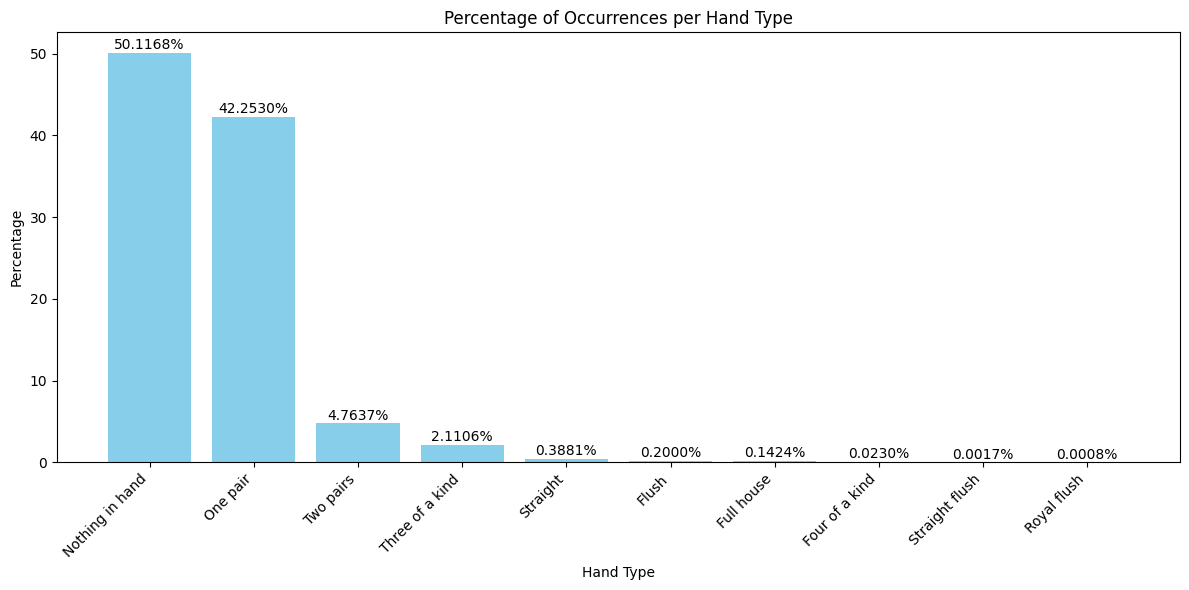

In [9]:
pandasdf = hand_percentages.select("*").toPandas()

pandasdf["Class"] = pandasdf["Class"].astype(int)

pandasdf["Class"] = pandasdf["Class"].map(class_mapping)

pandasdf.rename(columns={"Class": "Hand Type", "Occurrences": "Percentage"}, inplace=True)


# Create a bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(pandasdf["Hand Type"], pandasdf["Percentage"], color='skyblue')

# Add percentage values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.4f}%', ha='center', va='bottom')

plt.xlabel("Hand Type")
plt.ylabel("Percentage")
plt.title("Percentage of Occurrences per Hand Type")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()